# Setup

## Import

In [ ]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## User defined functions

In [18]:
def draw_roc_plot(fpr_rt_lm, tpr_rt_lm):
    # plot AUC curve
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
    metrics.auc(fpr_rt_lm, tpr_rt_lm)

# Modeling

In [5]:
# read in the dataset
df_imputed = pd.read_csv('model_ready_data.csv')

In [6]:
# train test split
df_train, df_test = train_test_split(df_imputed,test_size=0.33, random_state=42)

In [7]:
# seperate predictor and target variabel
target_train = df_train['Survived'] 
target_test = df_test['Survived']
df_train=df_train.drop(["Survived"],axis=1)
df_test=df_test.drop(["Survived"],axis=1)

In [31]:
# create model object
rf = RandomForestClassifier(n_estimators=500,max_depth=20)
# fit model
rf.fit(df_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
#Get the prediction in probability
clf_probs = rf.predict_proba(df_test) 

In [33]:
# Calculate AUC
fpr_rt_lm, tpr_rt_lm, _ = metrics.roc_curve(target_test,clf_probs[:, 1])
metrics.auc(fpr_rt_lm, tpr_rt_lm)
#Run ROC and get AUC value

0.86585714285714288

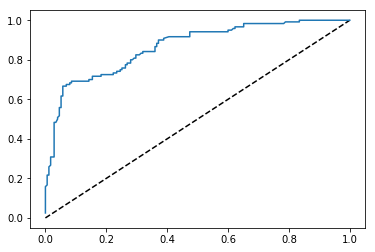

In [34]:
draw_roc_plot(fpr_rt_lm, tpr_rt_lm)

In [29]:
# Choose the parameters and its range
tuned_parameters = [{'n_estimators': [10, 100], 'max_depth': [2, 4]}]

scores = ['precision_macro', 'recall_macro', 'roc_auc']

#Tuning with three judgements
for score in scores:
    print "=" * 50
    print("# Tuning hyper-parameters for %s" % score)
    
    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10, n_jobs=-1,
                       scoring='%s' % score)
    clf.fit(df_train, target_train)
    
    print "-" * 50
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    
    print "-" * 50
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    param_sets = clf.cv_results_['params']
    for mean, std, params in zip(means, stds, param_sets):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
    print "-" * 50
    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    
    target_true, target_pred = target_test, clf.predict(df_test)
    print(classification_report(target_true, target_pred))
    
    clf_probs = clf.predict_proba(df_test) 
    fpr_rt_lm, tpr_rt_lm, _ = metrics.roc_curve(target_test,clf_probs[:, 1])
    
    print "-" * 50
    print ("Best AUC:")
    print(metrics.auc(fpr_rt_lm, tpr_rt_lm))
    
    

# Tuning hyper-parameters for precision_macro
--------------------------------------------------
Best parameters set found on development set:
{'n_estimators': 10, 'max_depth': 4}
--------------------------------------------------
Grid scores on development set:
0.772 (+/-0.176) for {'n_estimators': 10, 'max_depth': 2}
0.769 (+/-0.172) for {'n_estimators': 100, 'max_depth': 2}
0.796 (+/-0.192) for {'n_estimators': 10, 'max_depth': 4}
0.791 (+/-0.191) for {'n_estimators': 100, 'max_depth': 4}
--------------------------------------------------
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
             precision    recall  f1-score   support

          0       0.82      0.83      0.83       175
          1       0.75      0.74      0.74       120

avg / total       0.79      0.79      0.79       295

--------------------------------------------------
Best AUC:
0.877785714286
# Tuning hyper-parameters f

In [35]:
#Using feture importance to select features
importance = rf.feature_importances_
model = SelectFromModel(rf, prefit=True)
df_train_new = model.transform(df_train)
df_test_new = model.transform(df_test)
df_train_new.shape , df_test_new.shape

((596, 4), (295, 4))

In [37]:
#Fit model with optimal parameters and features
rfn = RandomForestClassifier(n_estimators=100,max_depth=4)
rfn.fit(df_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
#Recalculate the AUC in 'Better feature' testset
rfn_probs = rfn.predict_proba(df_test) #Get the prediction in probability
fpr_rfn_lm, tpr_rfn_lm, _ = metrics.roc_curve(target_test,rfn_probs[:, 1])
metrics.auc(fpr_rfn_lm, tpr_rfn_lm)

0.86814285714285711

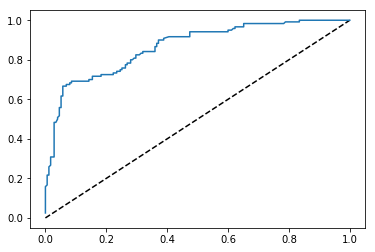

In [39]:
draw_roc_plot(fpr_rt_lm, tpr_rt_lm)